# 1. Dataset 1

## 1.0. Imports and Dataset

In [307]:
from functools import partial

import flax
from flax.training.train_state import TrainState
from jax import vmap
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
import optax
import seaborn as sns
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

import rebayes.datasets.datasets as dataset
import demos.collas.datasets.dataloaders as dataloaders
import rebayes.utils.models as models
import rebayes.utils.callbacks as callbacks
import rebayes.sgd_filter.sgd as sgd
import demos.collas.hparam_tune as hparam_tune
import demos.collas.train_utils as train_utils
import demos.collas.run_classification_experiments as experiments

In [308]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


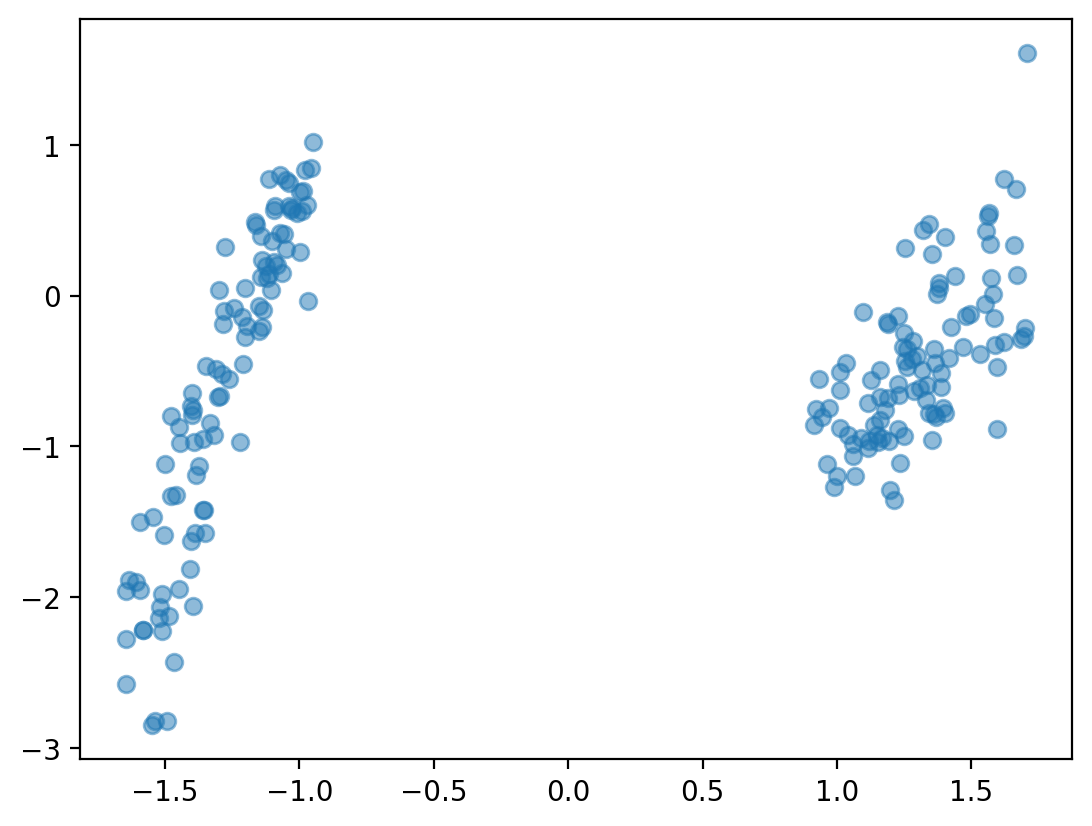

In [309]:
train, test = dataset.load_1d_synthetic_dataset(trenches=True, n_train=200)

X_train, y_train = train
X_test, y_test = test

plt.scatter(X_train, y_train, alpha=0.5);

In [310]:
model_init_fn = partial(models.initialize_regression_mlp,
                        input_dim=(1,), hidden_dims=[50,] * 2,
                        emission_cov=0.3)

## 1.1. FCEKF

### 1.1.1. Plug-In Approximation

In [5]:
pbounds = {
    'log_init_cov': (-10, 1.0),
    'log_1m_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-90, -90),
}
rmse_callback = partial(
    callbacks.cb_eval,
    evaluate_fn = lambda w, apply_fn, x, y: \
        {
            "rmse": -jnp.sqrt(jnp.mean((y - vmap(apply_fn, (None, 0))(w, x))**2)),
        }
)

In [6]:
fcekf_optimizer = hparam_tune.create_optimizer(
    model_init_fn, pbounds, train, train, callback=rmse_callback,
    method="fcekf", callback_at_end=False,
)

In [303]:
features = [50, 50, 50]
S = f"mlp_{features}_hi"
S

'mlp_[50, 50, 50]_hi'

In [7]:
fcekf_optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | log_1m... | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.7763   | -90.0     | -90.0     | -90.0     | -4.006    |
| 2         | -0.641    | -90.0     | -90.0     | -90.0     | -0.1905   |
| 3         | -0.7812   | -90.0     | -90.0     | -90.0     | -4.182    |
| 4         | -0.9166   | -90.0     | -90.0     | -90.0     | -9.042    |
| 5         | -0.6357   | -90.0     | -90.0     | -90.0     | -0.4299   |
| 6         | -0.6705   | -90.0     | -90.0     | -90.0     | -1.471    |
| 7         | -0.6594   | -90.0     | -90.0     | -90.0     | 1.0       |
| 8         | -0.6521   | -90.0     | -90.0     | -90.0     | -0.7555   |
| 9         | -0.8115   | -90.0     | -90.0     | -90.0     | -6.444    |
| 10        | -0.6962   | -90.0     | -90.0     | -90.0     | -2.465    |
| 11        | -0.6305   | -90.0     | -90.0     | -90.0     | 0.4965    |
| 12        | -0.6304   | -90.0     | 

In [8]:
hparams = hparam_tune.get_best_params(fcekf_optimizer, "fcekf")
estimator = hparam_tune.build_estimator(model_init_fn, hparams, "fcekf", False)
model = model_init_fn()

In [221]:
# Train
bel, _ = estimator["agent"].scan(
    model["flat_params"], estimator["init_cov"],
    X_train, y_train,
)

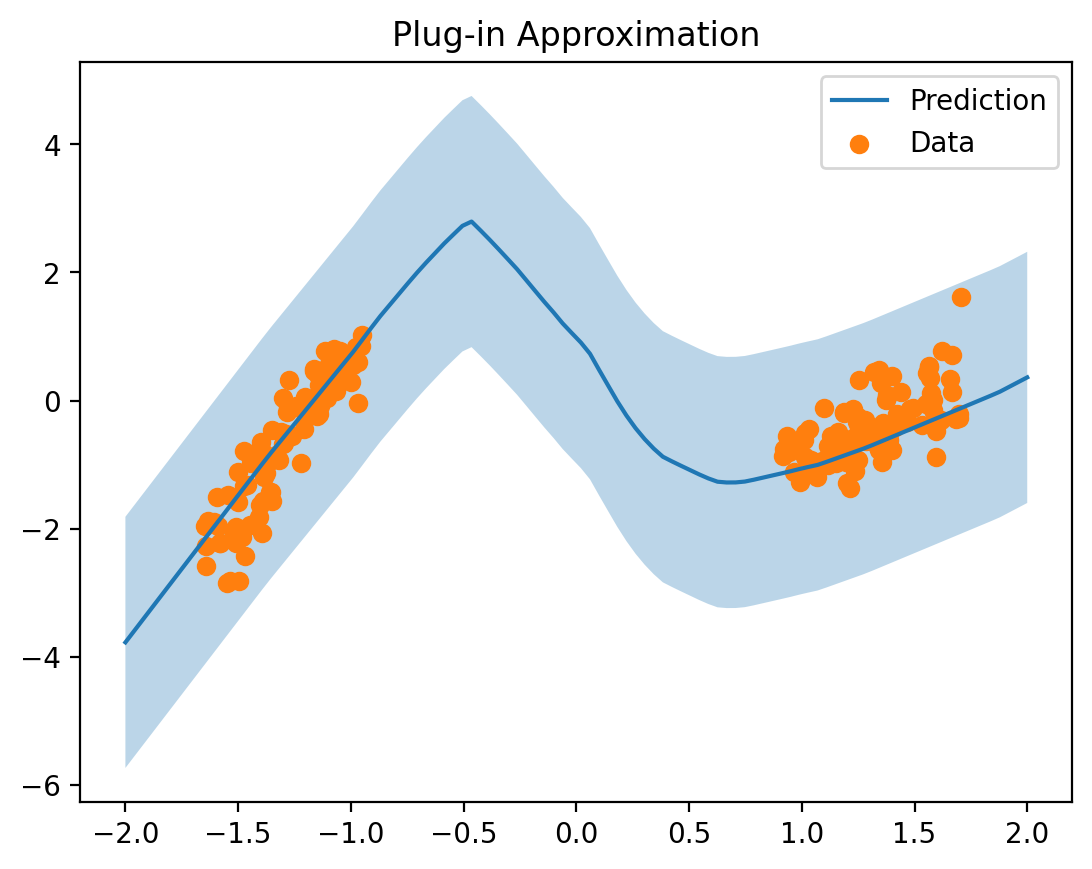

In [10]:
x_grid = jnp.linspace(-2, 2, 100)

# Point estimate
y_preds = vmap(model["apply_fn"], (None, 0))(bel.mean, x_grid).ravel()

# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, y_preds, label="Prediction")
ax.fill_between(
    x_grid, y_preds -1.96, y_preds + 1.96, alpha=0.3,
)
ax.scatter(X_train, y_train, label="Data")
ax.legend()
ax.set_title("Plug-in Approximation")
plt.show();

### 1.1.2. Linearized Approximation

In [28]:
x_grid = jnp.linspace(-2, 2, 100)

# Point estimate
y_preds = vmap(model["apply_fn"], (None, 0))(bel.mean, x_grid).ravel()

# Obs covariance
obs_stds = jnp.sqrt(vmap(estimator["agent"].predict_obs_cov, (None, 0))(bel, x_grid).ravel())

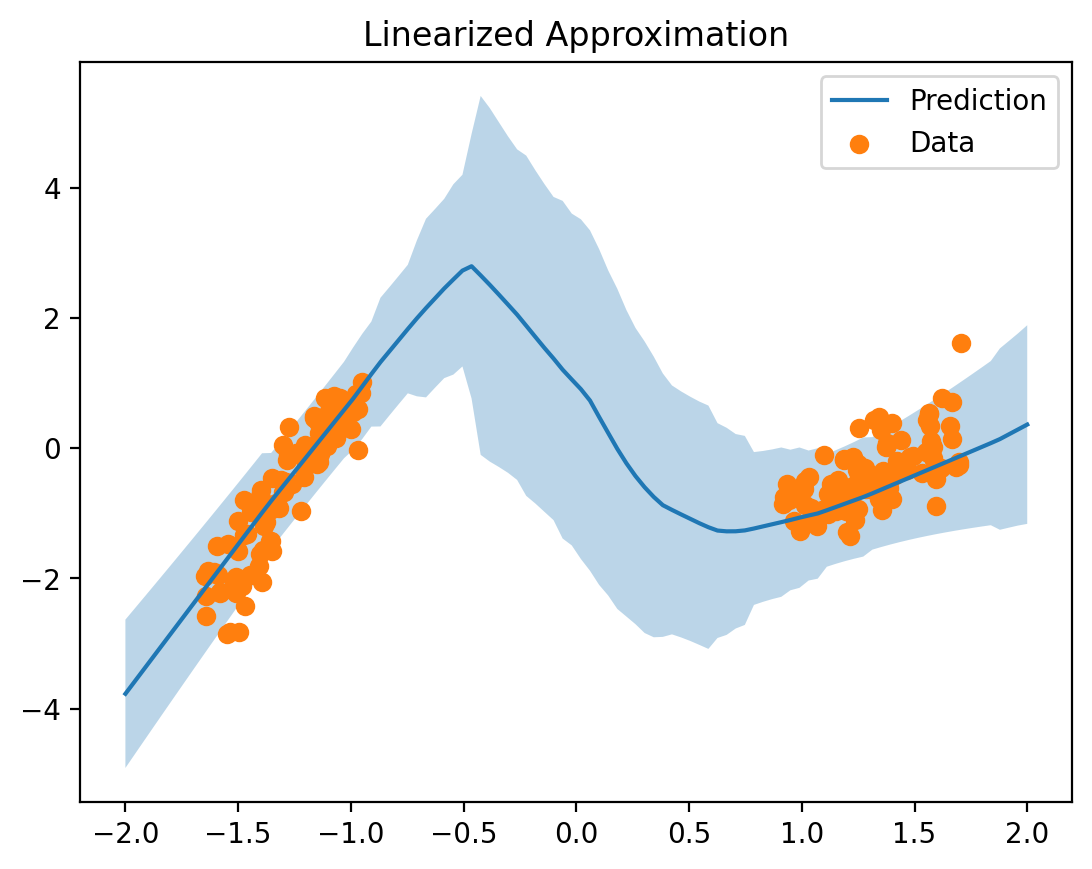

In [30]:
# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, y_preds, label="Prediction")
ax.fill_between(
    x_grid, y_preds - obs_stds, y_preds + obs_stds, alpha=0.3,
)
ax.scatter(X_train, y_train, label="Data")
ax.legend()
ax.set_title("Linearized Approximation")
plt.show();

## 1.2. SGD

### 1.2.1. Point Estimate

In [311]:
tx = optax.sgd(learning_rate=1e-3)
opt_state = tx.init(model["flat_params"])
train_state = TrainState(
    step=0, apply_fn=model["apply_fn"], params=model["flat_params"], tx=tx,
    opt_state=opt_state
)
def sgd_loss(params, x, y, apply_fn):
    prediction = vmap(apply_fn, (None, 0))(params, x).ravel()
    loss = jnp.sqrt(jnp.mean((prediction - y.ravel()) ** 2))
    
    return loss

state, losses = sgd.train_full(
    key=jr.PRNGKey(0), num_epochs=5000, batch_size=8, state=train_state,
    X=X_train, y=y_train, loss=sgd_loss, X_test=None, y_test=None,
)

In [312]:
sgd_y_preds = vmap(model["apply_fn"], (None, 0))(state.params, x_grid).ravel()

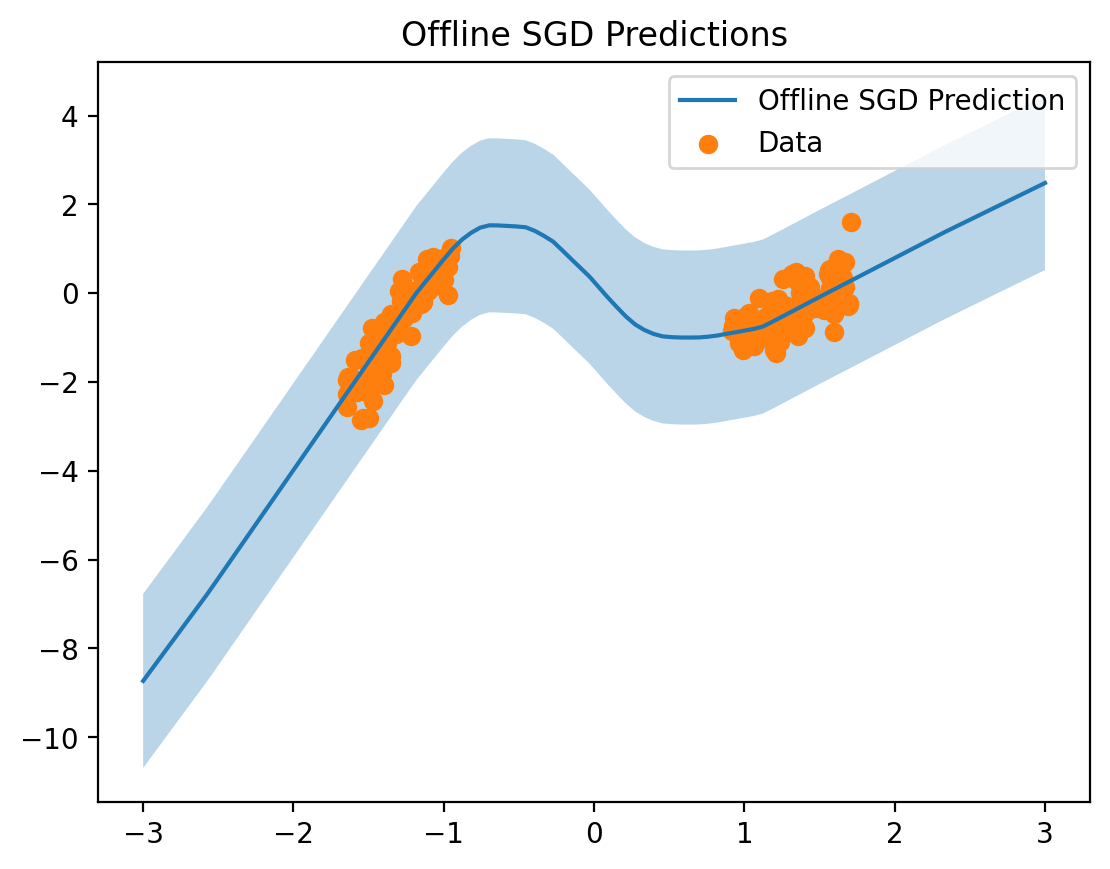

In [313]:
# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, sgd_y_preds, label="Offline SGD Prediction")
ax.fill_between(
    x_grid, sgd_y_preds -1.96, sgd_y_preds + 1.96, alpha=0.3,
)
ax.scatter(X_train, y_train, label="Data")
ax.legend()
ax.set_title("Offline SGD Predictions")
plt.show();

### 1.2.2. Neural-Linear

In [130]:
def generate_sub_networks(model_init_fn, flat_params, layer_start=0, layer_end=-1):
    params_dict = model_init_fn(0)["unflatten_fn"](flat_params)
    model = model_init_fn(0)["model"]
    features, activation = model.features, model.activation
    if layer_end == -1 or layer_end >= len(features):
        layer_end = len(features)
        activation = lambda x: x
    if layer_start > len(features):
        raise ValueError(f"layer_start must be less than {len(features)}")
    if layer_end < layer_start:
        raise ValueError(f"layer_end must be greater than layer_start")
    model.features = features[layer_start:layer_end]
    if layer_start == 0:
        input_dim, *_ = params_dict["Dense_0"]["kernel"].shape
    else:
        input_dim = features[layer_start - 1]
    params = {
        f"Dense_{i-layer_start}": 
            params_dict[f"Dense_{i}"] for i in range(layer_start, layer_end)
    }
    params = flax.core.frozen_dict.freeze(params)
    apply_fn = lambda x: activation(model.apply({"params": params}, x))
    
    sub_model_dict = {
        "model": model,
        "params": params,
        "apply_fn": apply_fn,
        "activation": activation,
        "input_dim": input_dim,
        "output_dim": features[layer_end - 1],
    }
    
    return sub_model_dict

In [131]:
abridged_model = generate_sub_networks(
    model_init_fn, state.params, 0, 2
)

In [215]:
x_grid = jnp.linspace(-3, 3, 100)

sgd_y_preds = vmap(model["apply_fn"], (None, 0))(state.params, x_grid).ravel()
phi_train = vmap(abridged_model["apply_fn"])(X_train)
phi_test = vmap(abridged_model["apply_fn"])(x_grid)

In [216]:
post_cov = phi_test @ jnp.linalg.pinv(phi_train.T @ phi_train/0.3 + jnp.eye(phi_train.shape[-1])) @ phi_test.T
post_cov += 1e-2 * jnp.eye(len(post_cov)) # to ensure positive definiteness
post_std = jnp.sqrt(jnp.diag(post_cov))

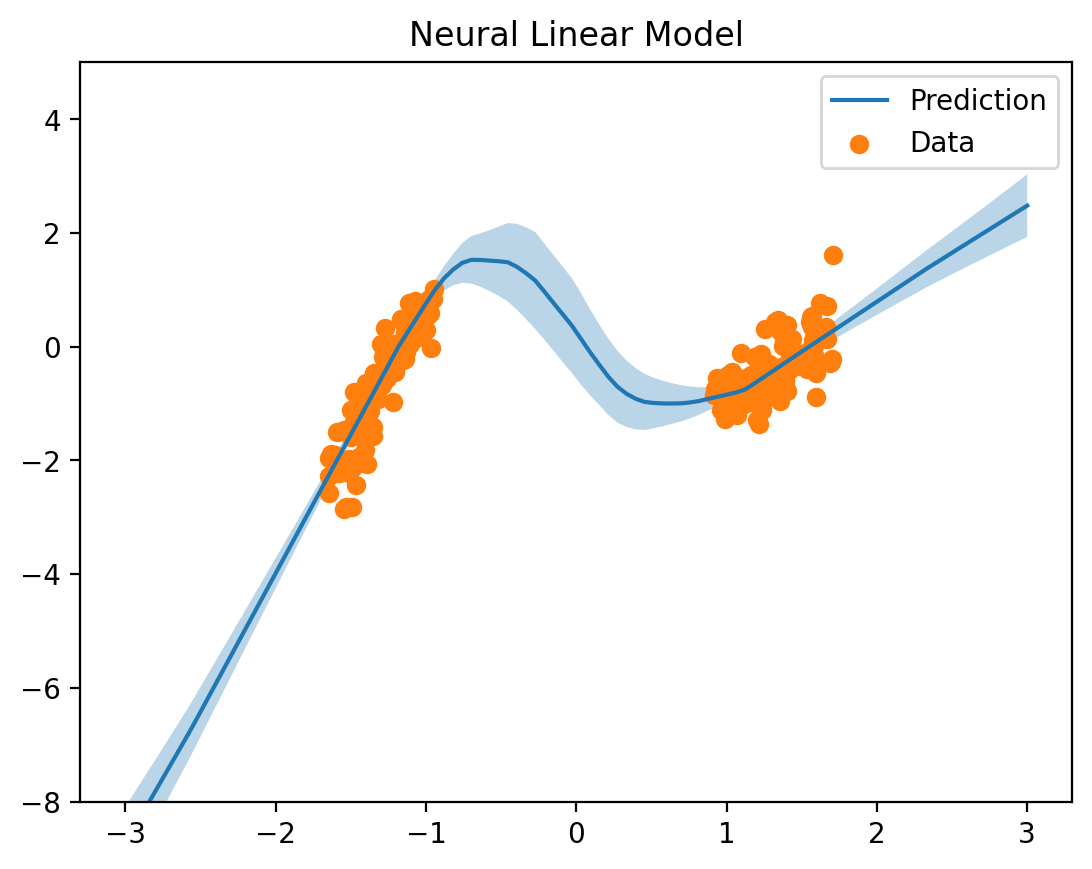

In [219]:
# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, sgd_y_preds, label="Prediction")
ax.fill_between(
    x_grid, sgd_y_preds - post_std, sgd_y_preds + post_std, alpha=0.3,
)
ax.scatter(X_train, y_train, label="Data")
ax.legend()
ax.set_ylim(-8.0, 5.0)
ax.set_title("Neural Linear Model")
plt.show();

### 1.2.3. Neural-EKF

In [193]:
def construct_linear_stitching(model1, model2, emission_cov=0.3, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    input_dim, output_dim = model1["output_dim"], model2["input_dim"]
    
    # Construct linear stitching
    linear_model = models.MLP(features=[output_dim,], activation=lambda x: x)
    params = linear_model.init(key, jnp.ones((input_dim,)))["params"]
    flat_params, unflatten_fn = ravel_pytree(params)
    linear_apply_fn = lambda w, x: linear_model.apply({"params": unflatten_fn(w)}, x)
    
    def apply_fn(w, x):
        input = model1["apply_fn"](x)
        linear_output = linear_apply_fn(w, input)
        output = model2["apply_fn"](linear_output).ravel()
        return output
    
    emission_mean_function = apply_fn
    emission_cov_function = lambda w, x: emission_cov * jnp.eye(model2["output_dim"])
    
    linear_model_dict = {
        "model": linear_model,
        "flat_params": flat_params,
        "unflatten_fn": unflatten_fn,
        "apply_fn": apply_fn,
        "emission_mean_function": emission_mean_function,
        "emission_cov_function": emission_cov_function,
    }
    
    return linear_model_dict

In [195]:
model1 = generate_sub_networks(model_init_fn, state.params, 0, 1)
model2 = generate_sub_networks(model_init_fn, state.params, 1, 3)

In [196]:
linear_model_init_fn = lambda key: construct_linear_stitching(model1, model2, key=key)

In [197]:
pbounds = {
    'log_init_cov': (-10, 1.0),
    'log_1m_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-90, -90),
}
rmse_callback = partial(
    callbacks.cb_eval,
    evaluate_fn = lambda w, apply_fn, x, y: \
        {
            "rmse": -jnp.sqrt(jnp.mean((y - vmap(apply_fn, (None, 0))(w, x))**2)),
        }
)

linear_fcekf_optimizer = hparam_tune.create_optimizer(
    linear_model_init_fn, pbounds, train, train, callback=rmse_callback,
    method="fcekf", callback_at_end=False,
)

In [222]:
linear_fcekf_optimizer.maximize(init_points=5, n_iter=10)

In [199]:
linear_hparams = hparam_tune.get_best_params(linear_fcekf_optimizer, "fcekf")
linear_estimator = hparam_tune.build_estimator(linear_model_init_fn, linear_hparams, 
                                               "fcekf", False)
linear_model = linear_model_init_fn(0)

In [200]:
# Train
stitch_bel, _ = linear_estimator["agent"].scan(
    linear_model["flat_params"], linear_estimator["init_cov"],
    X_train, y_train,
)

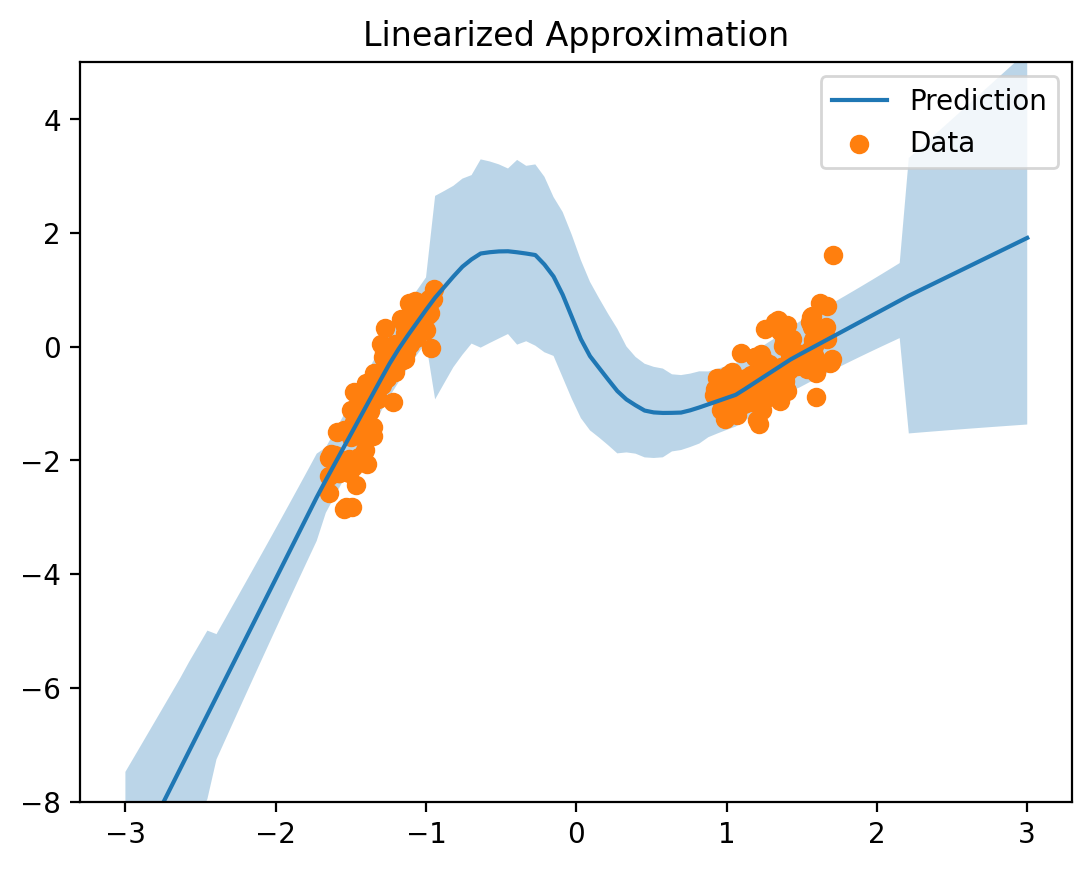

In [220]:
x_grid = jnp.linspace(-3, 3, 100)

# Point estimate
y_preds = vmap(linear_model["apply_fn"], (None, 0))(stitch_bel.mean, x_grid).ravel()

stitch_obs_stds = jnp.sqrt(vmap(linear_estimator["agent"].predict_obs_cov, (None, 0))(stitch_bel, x_grid).ravel())

# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, y_preds, label="Prediction")
ax.fill_between(
    x_grid, y_preds - stitch_obs_stds, y_preds + stitch_obs_stds, alpha=0.3,
)
ax.scatter(X_train, y_train, label="Data")
ax.legend()
ax.set_ylim(-8.0, 5.0)
ax.set_title("Linearized Approximation")
plt.show();

## 1.3. SGD Pre-Trained on OOD Dataset

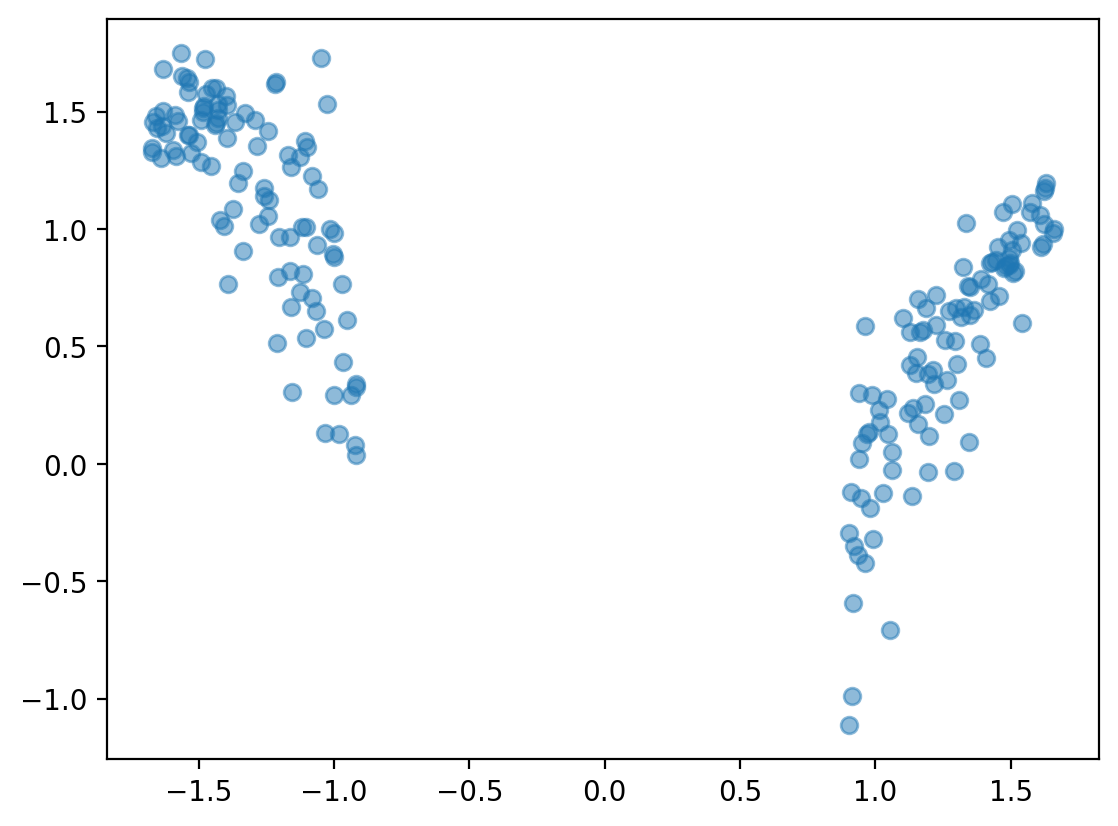

In [224]:
def ood_generating_function(key, x):
    epsilons = jr.normal(key, shape=(3,))*0.02
    return (x + 0.3*jnp.cos(2*jnp.pi*(x+epsilons[0])) +
            0.3*jnp.cos(4*jnp.pi*(x+epsilons[1])) + epsilons[2])

train2, test2 = dataset.load_1d_synthetic_dataset(trenches=True, n_train=200,
                                                  key=1, generating_function=ood_generating_function)

X_train2, y_train2 = train2
X_test2, y_test2 = test2

plt.scatter(X_train2, y_train2, alpha=0.5);

In [225]:
# We "pre-train" SGD using this training dataset
tx = optax.sgd(learning_rate=1e-3)
opt_state = tx.init(model["flat_params"])
train_state = TrainState(
    step=0, apply_fn=model["apply_fn"], params=model["flat_params"], tx=tx,
    opt_state=opt_state
)
def sgd_loss(params, x, y, apply_fn):
    prediction = vmap(model["apply_fn"], (None, 0))(params, x).ravel()
    loss = jnp.sqrt(jnp.mean((prediction - y.ravel()) ** 2))
    
    return loss

state, losses = sgd.train_full(
    key=jr.PRNGKey(0), num_epochs=5000, batch_size=8, state=train_state,
    X=X_train2, y=y_train2, loss=sgd_loss, X_test=None, y_test=None,
)

In [230]:
x_grid = jnp.linspace(-2, 2, 100)

sgd_y_preds = vmap(model["apply_fn"], (None, 0))(state.params, x_grid).ravel()

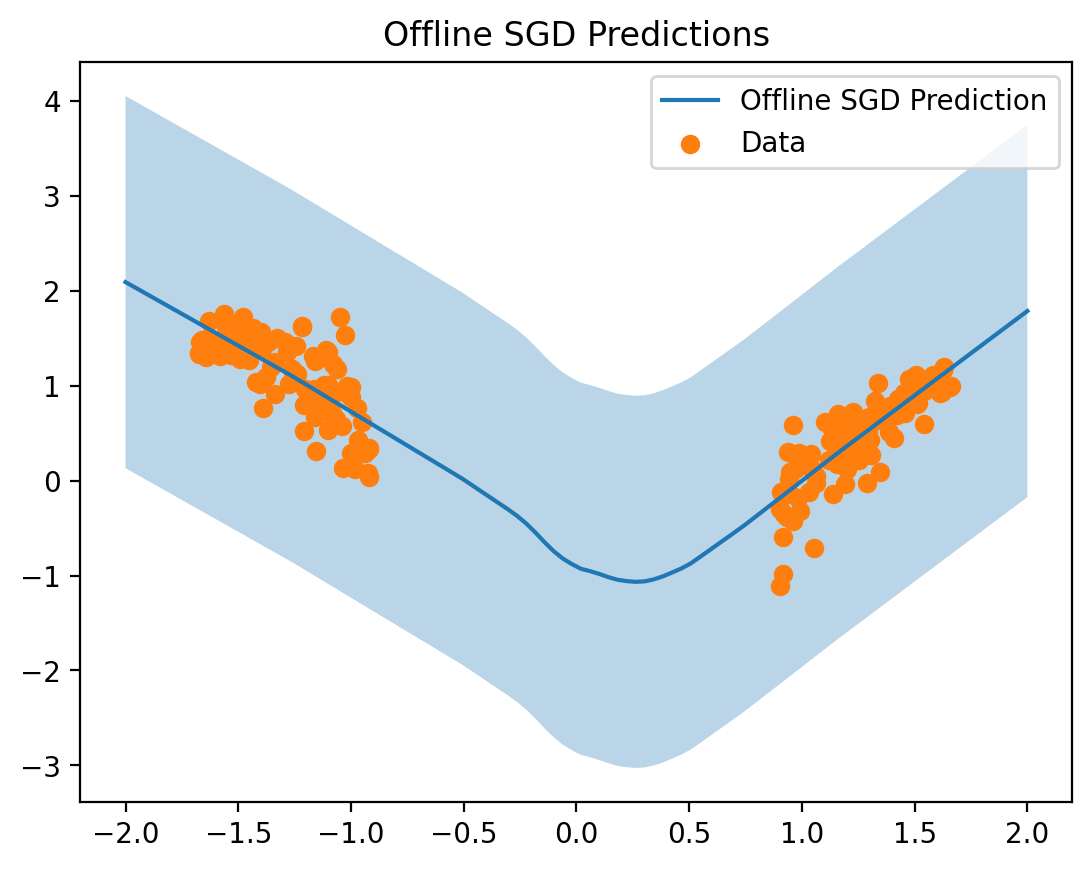

In [232]:
# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, sgd_y_preds, label="Offline SGD Prediction")
ax.fill_between(
    x_grid, sgd_y_preds -1.96, sgd_y_preds + 1.96, alpha=0.3,
)
ax.scatter(X_train2, y_train2, label="Data")
ax.legend()
ax.set_title("Offline SGD Predictions")
plt.show();

In [233]:
model1 = generate_sub_networks(model_init_fn, state.params, 0, 1)
model2 = generate_sub_networks(model_init_fn, state.params, 1, 3)

In [234]:
linear_model_init_fn = lambda key: construct_linear_stitching(model1, model2, key=key)

In [237]:
pbounds = {
    'log_init_cov': (-10, 2.0),
    'log_1m_dynamics_weights': (-90, -90),
    'log_dynamics_cov': (-90, -90),
    'log_alpha': (-90, -90),
}
rmse_callback = partial(
    callbacks.cb_eval,
    evaluate_fn = lambda w, apply_fn, x, y: \
        {
            "rmse": -jnp.sqrt(jnp.mean((y - vmap(apply_fn, (None, 0))(w, x))**2)),
        }
)

linear_fcekf_optimizer = hparam_tune.create_optimizer(
    linear_model_init_fn, pbounds, train, train, callback=rmse_callback,
    method="fcekf", callback_at_end=False,
)

In [238]:
linear_fcekf_optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | log_1m... | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.825    | -90.0     | -90.0     | -90.0     | -3.461    |
| 2         | -0.6177   | -90.0     | -90.0     | -90.0     | 0.7013    |
| 3         | -0.8294   | -90.0     | -90.0     | -90.0     | -3.653    |
| 4         | -0.9679   | -90.0     | -90.0     | -90.0     | -8.954    |
| 5         | -0.6356   | -90.0     | -90.0     | -90.0     | 0.4401    |
| 6         | -0.6054   | -90.0     | -90.0     | -90.0     | 2.0       |
| 7         | -0.597    | -90.0     | -90.0     | -90.0     | 1.455     |
| 8         | -0.5907   | -90.0     | -90.0     | -90.0     | 1.304     |
| 9         | -0.7286   | -90.0     | -90.0     | -90.0     | -1.269    |
| 10        | -0.8611   | -90.0     | -90.0     | -90.0     | -6.204    |
| 11        | -0.6172   | -90.0     | -90.0     | -90.0     | 1.126     |
| 12        | -0.7912   | -90.0     | 

In [240]:
ood_hparams = hparam_tune.get_best_params(linear_fcekf_optimizer, "fcekf")
ood_estimator = hparam_tune.build_estimator(linear_model_init_fn, hparams, "fcekf", False)
ood_model = linear_model_init_fn(0)

In [241]:
# Train
ood_bel, _ = ood_estimator["agent"].scan(
    ood_model["flat_params"], ood_estimator["init_cov"],
    X_train, y_train,
)

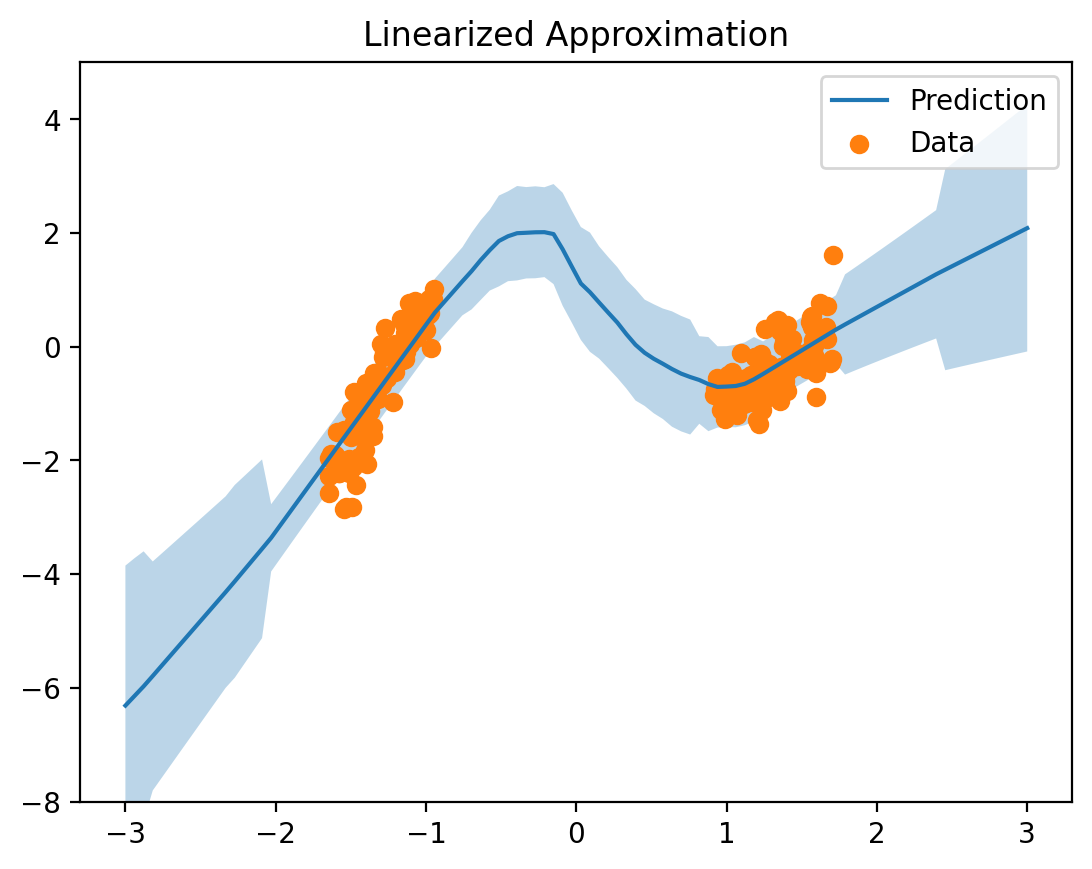

In [242]:
x_grid = jnp.linspace(-3, 3, 100)

# Point estimate
y_preds = vmap(ood_model["apply_fn"], (None, 0))(ood_bel.mean, x_grid).ravel()

ood_obs_stds = jnp.sqrt(vmap(ood_estimator["agent"].predict_obs_cov, (None, 0))(ood_bel, x_grid).ravel())

# Plot
fig, ax = plt.subplots()
ax.plot(x_grid, y_preds, label="Prediction")
ax.fill_between(
    x_grid, y_preds - ood_obs_stds, y_preds + ood_obs_stds, alpha=0.3,
)
ax.scatter(X_train, y_train, label="Data")
ax.legend()
ax.set_ylim(-8.0, 5.0)
ax.set_title("Linearized Approximation")
plt.show();

# 2. Dataset 2

## 2.0 Dataset

In [298]:
def f1(x, key, obs_var):
    w = jnp.array([-0.6667, -0.6012, -1.0172, -0.7687, 1.4680, -0.1678])
    fx = w @ jnp.power(x, jnp.arange(len(w)))
    fx *= jnp.sin(jnp.pi * x)
    fx *= jnp.exp(-0.5 * (x**2)) / jnp.sqrt(2 * jnp.pi)
    return fx + obs_var * jr.normal(key)

def f2(x, key, obs_var):
    fx = jnp.exp(jnp.abs(x))
    fx *= jnp.cos(2*jnp.pi * x)
    return fx + obs_var * jr.normal(key)

In [299]:
def generate_dataset(n_train, obs_var, gen_fn, key=42, in_between=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    
    if in_between:
        mask = jr.bernoulli(key, p=0.5, shape=(n_train,))
        key1, key2, subkey = jr.split(subkey, 3)
        X_train = (-2 * jr.uniform(key1, (n_train,)) - 1) * mask + \
            (2 * jr.uniform(key2, (n_train,)) + 1) * (1. - mask)
    else:
        X_train = jr.normal(key, (n_train,))
    
    keys = jr.split(subkey, n_train)
    y_train = vmap(gen_fn, (0, 0, None))(X_train, keys, obs_var)

    return X_train, y_train


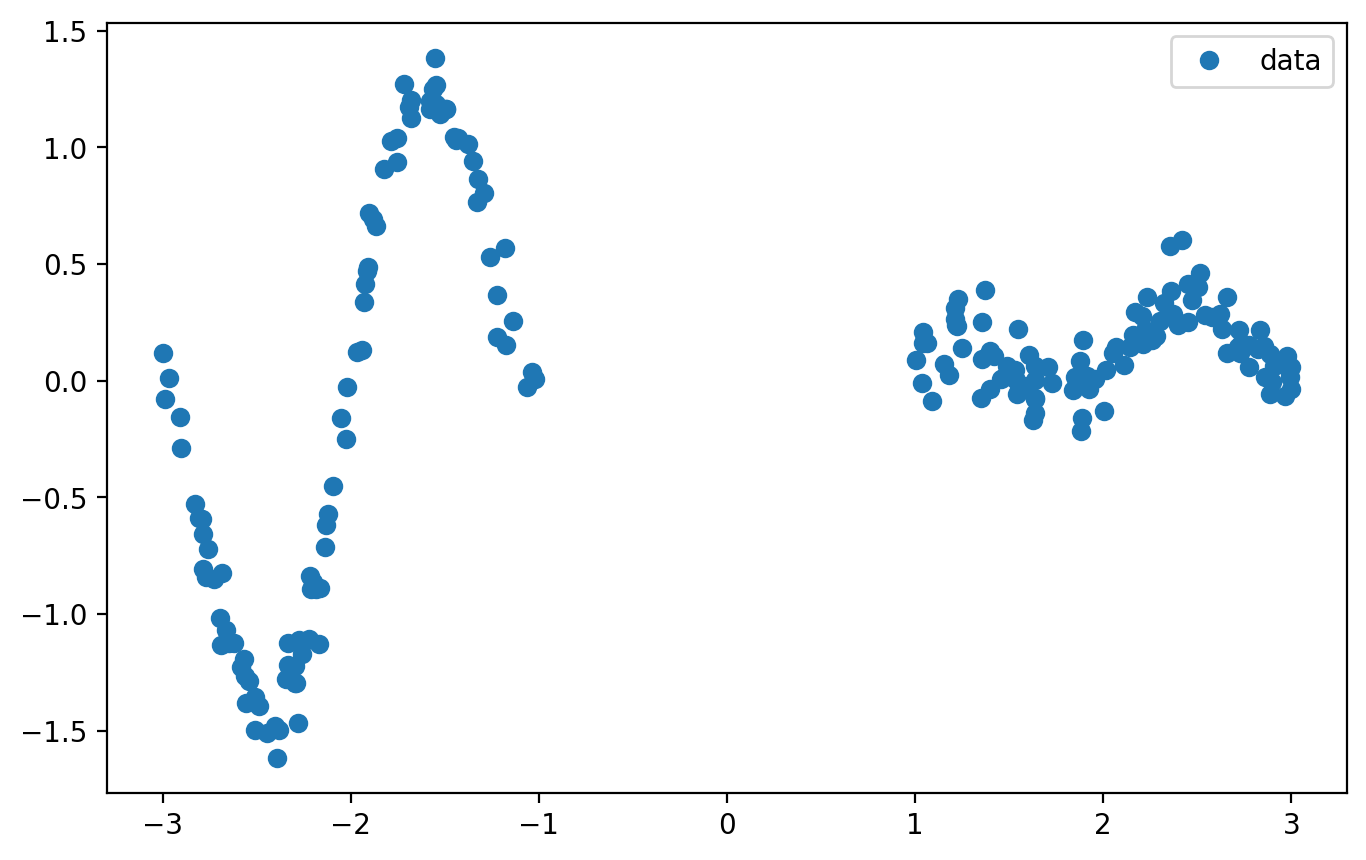

In [300]:
X_train, y_train = generate_dataset(200, 0.1, f1, 0, in_between=True)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_train, y_train, "o", label="data")
plt.legend(loc="best")
plt.show()

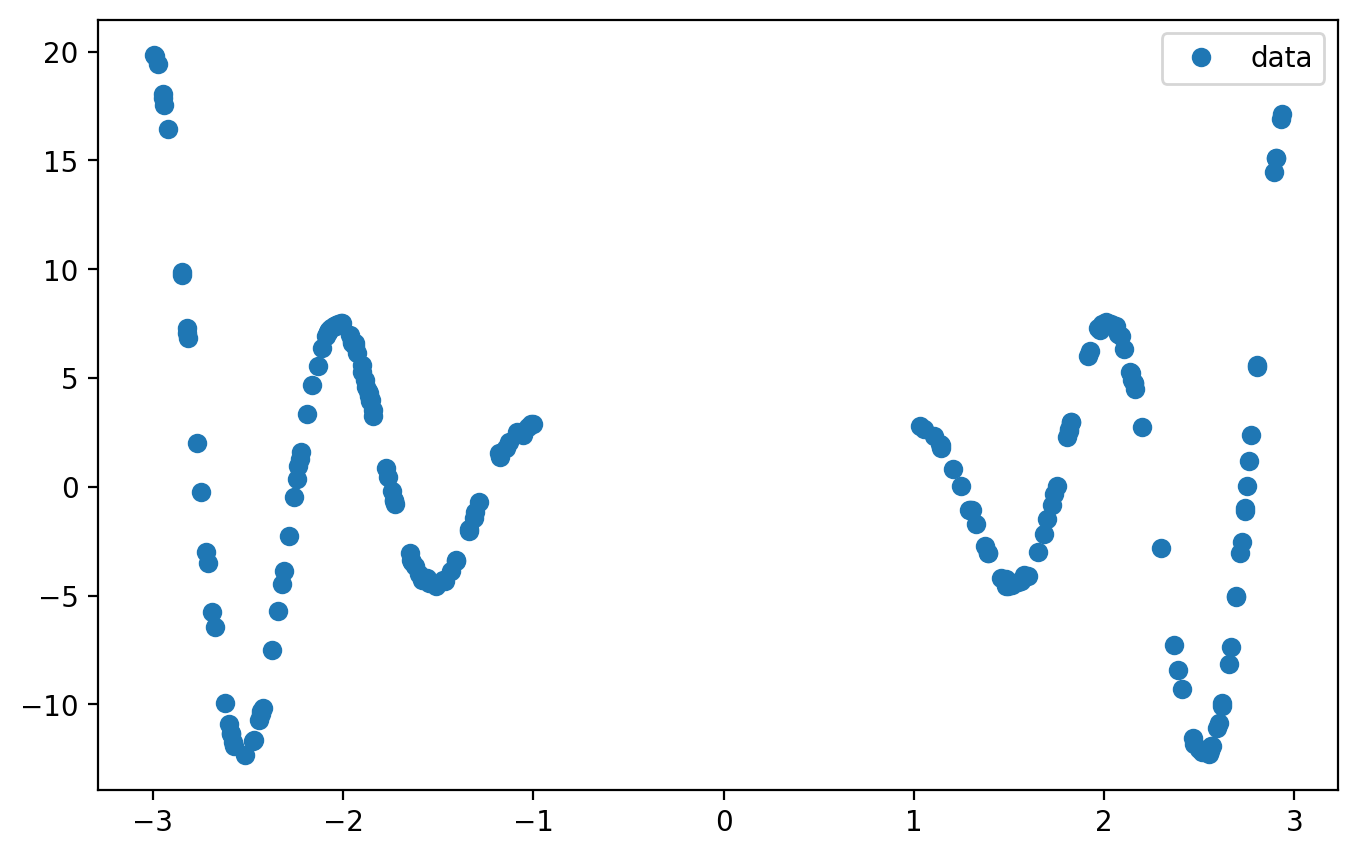

In [301]:
X_train, y_train = generate_dataset(200, 0.1, f2, 20, in_between=True)
# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_train, y_train, "o", label="data")
plt.legend(loc="best")
plt.show()

In [321]:
%run stitch.py

Tuning offline-sgd hyperparameters...
|   iter    |  target   | log_le... |
-------------------------------------
| 1         | -0.126    | -4.996    |
| 2         | -0.6726   | -1.356    |
| 3         | -0.5894   | -9.999    |
| 4         | -0.3582   | -6.372    |
| 5         | -0.5379   | -8.239    |
| 6         | -0.562    | -8.892    |
| 7         | -0.5086   | -7.765    |
| 8         | -0.1597   | -5.853    |
| 9         | -0.1264   | -5.239    |
| 10        | -0.1217   | -3.534    |
| 11        | -1e+08    | 2.0       |
| 12        | -0.1772   | -2.25     |
| 13        | -0.2171   | -1.75     |
| 14        | -0.1542   | -2.939    |
| 15        | -0.58     | -9.532    |
| 16        | -0.1186   | -4.217    |
| 17        | -0.4349   | -7.066    |
| 18        | -0.1616   | -2.595    |
| 19        | -0.121    | -4.575    |
| 20        | -0.4656   | -7.405    |


In [322]:
%run stitch.py --agent fcekf

Tuning fcekf hyperparameters...
|   iter    |  target   | log_1m... | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8057   | -90.0     | -90.0     | -90.0     | -3.461    |
| 2         | -1.07     | -90.0     | -90.0     | -90.0     | 0.7013    |
| 3         | -0.7989   | -90.0     | -90.0     | -90.0     | -3.653    |
| 4         | -0.7242   | -90.0     | -90.0     | -90.0     | -8.954    |
| 5         | -1.086    | -90.0     | -90.0     | -90.0     | 0.4401    |
| 6         | -0.9686   | -90.0     | -90.0     | -90.0     | -0.6336   |
| 7         | -1.183    | -90.0     | -90.0     | -90.0     | 1.336     |
| 8         | -1.022    | -90.0     | -90.0     | -90.0     | -0.7092   |
| 9         | -0.843    | -90.0     | -90.0     | -90.0     | -2.588    |
| 10        | -0.8723   | -90.0     | -90.0     | -90.0     | -1.818    |
| 11        | -0.721    | -90.0     | -90.0     | -90.0     | -8.528    |
| 12  